<a href="https://colab.research.google.com/github/plaban1981/Huggingface_transformers_course/blob/main/Machinehack_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

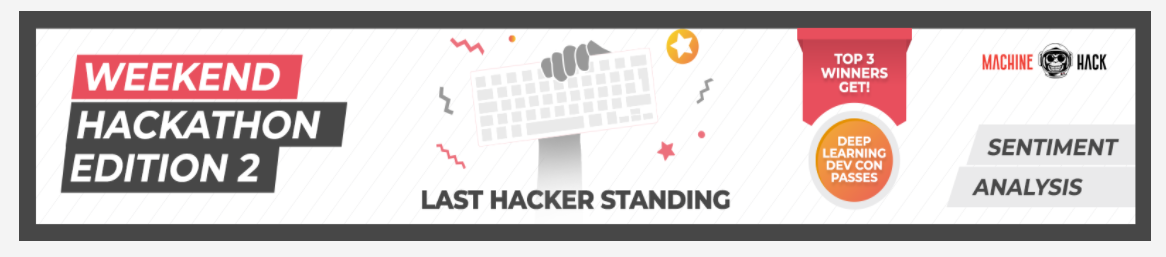

In [1]:
from google.colab import files
files.upload()

Saving Data_SAWE_2_LHS.zip to Data_SAWE_2_LHS.zip


In [2]:
from google.colab import drive
drive.mount("/content/disk")

Mounted at /content/disk


## Unzip Training Data

In [3]:
%%capture
!unzip "/content/Data_SAWE_2_LHS.zip"  -d "/content/disk/MyDrive/Machine_Hack"

##  Text cleaning using Text Hero

In [4]:
! pip install texthero

     |████████████████████████████████| 241 kB 7.3 MB/s 
     |████████████████████████████████| 1.5 MB 46.9 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Read training and test data

In [27]:
! pip install datasets

     |████████████████████████████████| 264 kB 4.8 MB/s 
     |████████████████████████████████| 243 kB 9.7 MB/s 
     |████████████████████████████████| 76 kB 3.8 MB/s 
     |████████████████████████████████| 118 kB 9.6 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [3]:
import pandas as pd
import texthero as hero
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/content/disk/MyDrive/Machine_Hack/train.csv")
test = pd.read_csv("/content/disk/MyDrive/Machine_Hack/test.csv")
sub = pd.read_csv("/content/disk/MyDrive/Machine_Hack/submission.csv")

In [5]:
train.head()

,ID,author,Review,Sentiment
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0
4,61178,aliisanoun,I remember all the hype around this movie when...,0


In [6]:
train['Cleaned_Review'] = hero.clean(train['Review'] )

In [9]:
train.head()

,ID,author,Review,Sentiment,Cleaned_Review
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2,today working quot quirky q quot cue maybe bec...
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1,shannonelizab dont ya know people love human s...
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0,ughhh rejected mediation program suckssss
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0,petewentz im jealous want octo drive
4,61178,aliisanoun,I remember all the hype around this movie when...,0,remember hype around movie aaliyah killed fan ...


In [10]:
test.head()

,ID,author,Review
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe..."
4,34410,phaoloo,@dharshana anytime


In [7]:
test['Cleaned_Review'] = hero.clean(test['Review'] )

In [8]:
test.head()

,ID,author,Review,Cleaned_Review
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name
4,34410,phaoloo,@dharshana anytime,dharshana anytime


In [10]:
test['Sentiment'] = 0

In [11]:
sub.head()

,Negative_0,Neutral_1,Positive_2
0,0,1,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


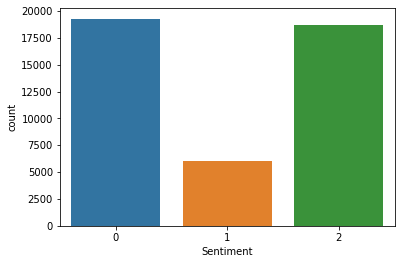

In [12]:
sns.countplot(x ='Sentiment',data= train)

## Extract Features and Labels

In [13]:
train_texts = train['Cleaned_Review'].values.tolist()
train_labels = train['Sentiment'].values.tolist()
test_texts = test['Cleaned_Review'].values.tolist()


## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,random_state=42,stratify=train_labels)

## Install Transformers

https://huggingface.co/transformers/training.html

In [16]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 
     |████████████████████████████████| 636 kB 41.8 MB/s 
     |████████████████████████████████| 3.3 MB 50.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Fine Tuning Custom models
* Prepare dataset
* Load pretrained tokenizer, call it with dataset
* Build Pytorch datasets with encodings
* Load pretrained Model
* Load Trainer and train it OR
use native Pytorch training Pipeline

## Import required transformer libraries

In [15]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

## Set Model Name

In [16]:
model_name  = 'distilbert-base-uncased'

## Tokenization

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')

* We can simply pass our texts to the tokenizer. We’ll pass truncation=True and padding=True, which will ensure that all of our sequences are padded to the same length and are truncated to be no longer model’s maximum input length

* This will allow us to feed batches of sequences into the model at the same time.

## Turn our labels and encodings into a Dataset object.
* In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing len and getitem.

In [19]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

## Genearte DataLoaders

In [21]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentTestDataset(test_encodings)

In [22]:
train_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

In [23]:
val_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

In [24]:
test_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

## Fine-tuning with Trainer

In [1]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [25]:
training_args = TrainingArguments(
    output_dir='./results1',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs1',            # directory for storing logs
    logging_steps=10
)

In [26]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset ,            # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Step,Training Loss
10,1.103300
20,1.102500
30,1.089700
40,1.060800
50,1.036800
60,0.990900
70,0.983700
80,1.014600
90,0.942300
100,0.982400


Saving model checkpoint to ./results1/checkpoint-500
Configuration saved in ./results1/checkpoint-500/config.json
Model weights saved in ./results1/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-1000
Configuration saved in ./results1/checkpoint-1000/config.json
Model weights saved in ./results1/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-1500
Configuration saved in ./results1/checkpoint-1500/config.json
Model weights saved in ./results1/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-2000
Configuration saved in ./results1/checkpoint-2000/config.json
Model weights saved in ./results1/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-2500
Configuration saved in ./results1/checkpoint-2500/config.json
Model weights saved in ./results1/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-3000
Configuration saved in ./resu

TrainOutput(global_step=6615, training_loss=0.5652016003566174, metrics={'train_runtime': 2964.7397, 'train_samples_per_second': 35.7, 'train_steps_per_second': 2.231, 'total_flos': 1.402059950678016e+16, 'train_loss': 0.5652016003566174, 'epoch': 3.0})

## Make predictions on TEST DATA

In [27]:
test.shape

(18900, 5)

In [45]:
test['Sentiment'] = 0
test_texts = test['Cleaned_Review'].values.tolist()
test_labels = test['Sentiment'].values.tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')
test_dataset = SentimentDataset(test_encodings, test_labels)

In [46]:
len(test_dataset)

18900

In [47]:
test_dataset[0]['input_ids'].__len__()

512

In [48]:
preds = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 18900
  Batch size = 64


In [49]:
preds[0]

array([[-0.59425986, -1.0663491 ,  2.3041823 ],
       [ 1.4057063 ,  0.30279717, -1.3212523 ],
       [ 5.1981883 , -3.6542513 , -0.8827134 ],
       ...,
       [ 2.3406234 , -0.48288953, -1.3829278 ],
       [ 0.4865898 , -0.04063616, -0.25722894],
       [-1.3042909 ,  1.0312462 ,  0.486922  ]], dtype=float32)

In [50]:
predictions = preds[0].tolist()

In [51]:
predictions = np.argmax(preds[0],axis=1).tolist()

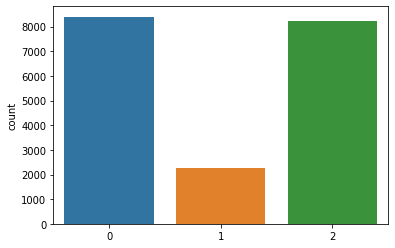

In [52]:
import seaborn as sns
sns.countplot(predictions)

In [53]:
test['Sentiment'] = predictions

In [54]:
test.head()

,ID,author,Review,Cleaned_Review,Sentiment
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot,2
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...,0
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...,0
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name,0
4,34410,phaoloo,@dharshana anytime,dharshana anytime,0


In [38]:
sub.head()

,Negative_0,Neutral_1,Positive_2
0,0,1,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


##Defining function to format prediction labels as required for submission

In [55]:
def labels(x):
  if x == 0:
    return 'Negative_0'
  elif x == 1:
    return 'Neutral_1'
  else:
    return 'Positive_2'
test['Sentiment'] = test['Sentiment'].map(labels)
test.head()

,ID,author,Review,Cleaned_Review,Sentiment
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot,Positive_2
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...,Negative_0
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...,Negative_0
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name,Negative_0
4,34410,phaoloo,@dharshana anytime,dharshana anytime,Negative_0


In [56]:
df = pd.get_dummies(test['Sentiment'])

In [57]:
df.head()

,Negative_0,Neutral_1,Positive_2
0,0,0,1
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [60]:
df.to_csv("distilbertprocessedtext.csv",index=False)

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis',model=model_name)
result = classifier(test_texts)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed

## Processing using TextHero

In [62]:
train.head()

,ID,author,Review,Sentiment,Cleaned_Review
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2,today working quot quirky q quot cue maybe bec...
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1,shannonelizab dont ya know people love human s...
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0,ughhh rejected mediation program suckssss
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0,petewentz im jealous want octo drive
4,61178,aliisanoun,I remember all the hype around this movie when...,0,remember hype around movie aaliyah killed fan ...


In [63]:
test.head()

,ID,author,Review,Cleaned_Review,Sentiment
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot,Positive_2
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...,Negative_0
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...,Negative_0
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name,Negative_0
4,34410,phaoloo,@dharshana anytime,dharshana anytime,Negative_0


## TFIDF vectorization on the cleaned text column

In [66]:
tfidf_output = hero.tfidf(train['Cleaned_Review'],max_features=200,return_feature_names=True)

In [67]:
train['tfidf_clean_text'] = tfidf_output[0]

In [68]:
train.head()

,ID,author,Review,Sentiment,Cleaned_Review,tfidf_clean_text
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2,today working quot quirky q quot cue maybe bec...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1,shannonelizab dont ya know people love human s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0,ughhh rejected mediation program suckssss,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0,petewentz im jealous want octo drive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,61178,aliisanoun,I remember all the hype around this movie when...,0,remember hype around movie aaliyah killed fan ...,"[0.05630414502164503, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [71]:
word_vector = train['tfidf_clean_text'].values.tolist()
word_document_matrix = np.array(word_vector)
word_document_matrix.shape

(44100, 200)

In [72]:
feature_names = tfidf_output[1]
len(feature_names)

200

In [73]:
final_train = pd.DataFrame(word_document_matrix,columns=feature_names)

In [75]:
final_train['label'] = train['Sentiment'].values.tolist()

In [76]:
final_train.head()

,acting,action,actor,actors,actually,almost,also,although,always,american,another,anyone,anything,around,away,back,bad,beautiful,believe,best,better,big,bit,book,br,cast,character,characters,come,comedy,comes,could,course,day,different,director,done,dvd,effects,end,...,something,still,story,sure,take,thing,things,think,though,thought,three,time,times,today,together,true,trying,tv,two,us,want,war,watch,watched,watching,way,well,whole,without,woman,work,world,worst,worth,would,year,years,yet,young,label
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.686041,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,0.056304,0.0,0.0,0.0,0.0,0.0,0.106014,0.0,0.0,0.073823,0.061586,0.0,0.0,0.128603,0.0,0.0,0.052979,0.0,0.0,0.0,0.0,0.0,0.0,0.075942,0.744911,0.0,0.117791,0.057491,0.0,0.0,0.0,0.053473,0.0,0.0,0.0,0.0,0.064935,0.0,0.0,0.0,...,0.118255,0.0,0.154317,0.132498,0.0,0.060526,0.0,0.053386,0.0,0.128687,0.0,0.046321,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.129958,0.060428,0.0,0.0,0.0,0.0,0.053015,0.0,0.0,0.065919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067406,0


In [78]:
from sklearn.model_selection import train_test_split
X = final_train.drop('label',axis=1)
Y = final_train['label']
train_texts, val_texts, train_labels, val_labels = train_test_split(X, Y, test_size=.2,random_state=42,stratify=Y)

In [79]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Accuracy Score : 0.5841269841269842
F1 Score : 0.5469241647336471
Accuracy Score : 0.5882086167800453
F1 Score : 0.5511807366090522
Accuracy Score : 0.5768707482993197
F1 Score : 0.5409256371411061
Accuracy Score : 0.5856009070294784
F1 Score : 0.5489314407736448
Accuracy Score : 0.5835600907029479
F1 Score : 0.5475458289196379
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.5768707482993197 0.5882086167800453 0.5836734693877551


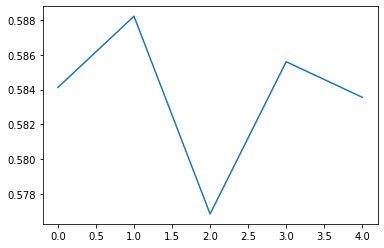

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
temp  = final_train.drop('label',axis=1)
target = final_train['label']
scores = []
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = LogisticRegression(multi_class='ovr')

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f'Accuracy Score : {accuracy_score(ytest,preds)}')
        f1 = f1_score(ytest, preds,average='weighted')
        print(f'F1 Score : {f1}')
        scores.append(accuracy_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))


In [90]:
tfidf_output_test = hero.tfidf(test['Cleaned_Review'],max_features=200,return_feature_names=True)
test['tfidf_clean_text'] = tfidf_output_test[0] 
word_vector = test['tfidf_clean_text'].values.tolist()
word_document_matrix = np.array(word_vector)
word_document_matrix.shape

(18900, 200)

In [91]:
final_test = pd.DataFrame(word_document_matrix,columns=feature_names)

In [92]:
y_pred = model.predict(final_test)

In [94]:
test['Sentiment'] = y_pred
test['Sentiment'] = test['Sentiment'].map(labels)
test.head()

,ID,author,Review,Cleaned_Review,Sentiment,tfidf_clean_text
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot,Positive_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...,Positive_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...,Negative_0,"[0.15110701953211284, 0.0, 0.0, 0.082566337845..."
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name,Negative_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,34410,phaoloo,@dharshana anytime,dharshana anytime,Negative_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [95]:
df = pd.get_dummies(test['Sentiment'])

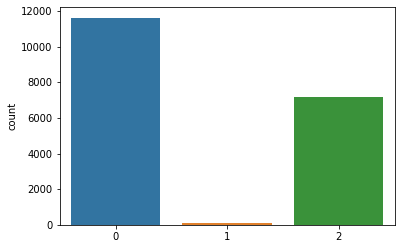

In [96]:
import seaborn as sns
sns.countplot(y_pred)

In [97]:
df.to_csv("lr.csv",index=False)

## Sentence transformers

In [98]:
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 2.7 MB/s 
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=aa6f8ce29b913c6786ecc1bde902b4205863e815cb98259787a85d2d88f10ce1
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


In [99]:
sentences = train['Cleaned_Review'].values.tolist()

In [102]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(sentences)
#print(embeddings)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

loading configuration file /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config.json
Model config DistilBertConfig {
  "_name_or_path": "old_models/distilbert-base-nli-mean-tokens/0_Transformer",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.9.1",
  "vocab_size": 30522
}

loading weights file /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoin

In [105]:
train_vector = pd.DataFrame(np.array(embeddings))
final_train = pd.concat((train_vector,train),axis=1)
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,ID,author,Review,Sentiment,Cleaned_Review,tfidf_clean_text
0,-1.051989,-0.459227,1.207026,-1.235972,0.303188,-1.195730,0.332849,-0.763395,1.346526,-0.766207,0.637632,-0.338034,0.231351,-0.143713,1.097104,-0.413063,-0.096819,-0.201737,-0.338007,-1.073574,0.517534,0.051561,0.254223,1.263525,-0.630559,-0.447768,0.778090,0.183570,-0.115685,1.167961,-0.247160,0.257186,0.426294,0.205552,0.045493,-0.123764,0.505725,0.164406,0.688011,-0.971506,...,-0.810260,-0.373130,0.196066,-0.195548,1.062412,0.277879,-0.024943,-0.244447,-0.464015,-1.262603,0.551653,0.038971,-0.414027,-0.381653,-0.505883,0.778881,0.610432,0.492020,0.286199,-0.866726,0.324698,-0.482863,-0.787826,-0.193299,0.581628,-0.713794,0.666591,0.485165,0.461560,0.105337,0.108611,-0.360844,0.360900,-0.245437,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2,today working quot quirky q quot cue maybe bec...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,-0.094143,-0.191318,0.784023,-0.168227,-0.543507,-0.406366,0.393366,-0.314447,-0.293885,-0.277688,-0.103101,0.668382,-1.221742,0.820982,0.024080,-0.564553,1.812798,0.754554,-0.799301,-0.469244,0.093205,0.069777,0.003555,0.247927,-0.358608,0.338045,0.327168,-0.302553,0.192909,-0.127479,0.069156,0.739187,-0.671826,-0.398124,0.033053,-0.192136,0.223622,0.388314,0.621132,-0.941077,...,1.051133,0.915010,-0.229974,0.773377,-0.042099,0.272000,-0.096187,-0.731818,-0.417146,-1.295552,0.245190,0.322486,-0.013227,0.209426,-0.544586,-0.403533,0.383115,0.479483,0.036237,-0.153625,-0.211194,0.247027,-0.972635,-0.026012,-1.599631,-0.389461,-0.262299,-0.119921,-0.308619,0.436956,0.069991,-0.594015,0.000494,-0.083690,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1,shannonelizab dont ya know people love human s...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,-0.528863,0.117295,-0.167343,-0.134065,-1.068288,-0.205922,0.267139,0.607061,0.273670,1.207739,0.031858,0.679989,0.491793,0.572906,0.731248,-0.324420,-1.138786,0.094016,-0.279849,-0.127839,-0.355240,0.333970,0.416810,0.405370,-1.351252,1.164116,1.080335,-0.420640,-0.113755,-0.136135,0.216958,0.499566,0.255444,-0.480834,0.470053,-0.279029,0.756891,0.512752,0.045441,0.103089,...,0.416284,0.190517,1.088273,0.407605,-0.089649,-1.321835,-0.465442,0.069849,-0.270015,-0.927442,-0.560986,0.738888,0.022653,-0.962093,-1.223678,0.079276,0.703345,0.495486,-0.082125,-1.154647,0.011202,-0.223672,-0.128662,0.064735,-0.870736,0.145248,0.205508,0.113923,0.185148,-0.496017,-0.138433,-0.017463,0.519190,0.135173,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0,ughhh rejected mediation program suckssss,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,-0.979348,0.092250,0.611265,-0.573964,-0.990446,-0.775413,-0.324490,0.458554,1.090201,0.729963,0.338096,0.921161,-0.188823,0.193451,0.229699,-0.573450,1.150592,0.566600,-0.650274,-0.622086,0.116069,0.159818,-0.517757,1.275922,-0.361368,0.980922,0.682609,-0.039311,-0.397767,0.528103,-0.157319,0.623969,-0.741694,0.517645,0.093564,-0.654476,0.628664,-1.257684,0.845140,-0.592696,...,-0.107692,-0.109869,0.515705,0.007830,0.240693,-0.458411,-0.234285,-0.428477,-0.335233,-1.297480,0.033296,0.258602,-0.137243,0.351134,-0.796054,-0.080569,0.082822,-0.134842,0.228979,-0.330794,-0.058675,-0.610226,-0.583553,0.292522,-0.930938,-1.426779,-0.566022,-0.445555,-0.284895,-0.016813,0.597617,-0.359160,0.042254,-0.828061,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0,petewentz im jealous want octo drive,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.240895,-0.292248,0.631131,-0.954095,-0.749118,-0.038735,-0.435986,-0.921421,0.946157,0.138446,0.586390,0.914012,-0.465982,1.162188,0.239246,-0.676380,0.264717,0.013978,0.086498,0.174

In [107]:
ft = final_train.drop(['ID','author','Review','Cleaned_Review','tfidf_clean_text'],axis=1)

In [108]:
ft.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Sentiment
0,-1.051989,-0.459227,1.207026,-1.235972,0.303188,-1.195730,0.332849,-0.763395,1.346526,-0.766207,0.637632,-0.338034,0.231351,-0.143713,1.097104,-0.413063,-0.096819,-0.201737,-0.338007,-1.073574,0.517534,0.051561,0.254223,1.263525,-0.630559,-0.447768,0.778090,0.183570,-0.115685,1.167961,-0.247160,0.257186,0.426294,0.205552,0.045493,-0.123764,0.505725,0.164406,0.688011,-0.971506,...,-0.766780,-0.943742,0.519173,-0.112380,0.666036,-0.810260,-0.373130,0.196066,-0.195548,1.062412,0.277879,-0.024943,-0.244447,-0.464015,-1.262603,0.551653,0.038971,-0.414027,-0.381653,-0.505883,0.778881,0.610432,0.492020,0.286199,-0.866726,0.324698,-0.482863,-0.787826,-0.193299,0.581628,-0.713794,0.666591,0.485165,0.461560,0.105337,0.108611,-0.360844,0.360900,-0.245437,2
1,-0.094143,-0.191318,0.784023,-0.168227,-0.543507,-0.406366,0.393366,-0.314447,-0.293885,-0.277688,-0.103101,0.668382,-1.221742,0.820982,0.024080,-0.564553,1.812798,0.754554,-0.799301,-0.469244,0.093205,0.069777,0.003555,0.247927,-0.358608,0.338045,0.327168,-0.302553,0.192909,-0.127479,0.069156,0.739187,-0.671826,-0.398124,0.033053,-0.192136,0.223622,0.388314,0.621132,-0.941077,...,-0.584938,0.059277,-0.326973,-0.399582,0.361230,1.051133,0.915010,-0.229974,0.773377,-0.042099,0.272000,-0.096187,-0.731818,-0.417146,-1.295552,0.245190,0.322486,-0.013227,0.209426,-0.544586,-0.403533,0.383115,0.479483,0.036237,-0.153625,-0.211194,0.247027,-0.972635,-0.026012,-1.599631,-0.389461,-0.262299,-0.119921,-0.308619,0.436956,0.069991,-0.594015,0.000494,-0.083690,1
2,-0.528863,0.117295,-0.167343,-0.134065,-1.068288,-0.205922,0.267139,0.607061,0.273670,1.207739,0.031858,0.679989,0.491793,0.572906,0.731248,-0.324420,-1.138786,0.094016,-0.279849,-0.127839,-0.355240,0.333970,0.416810,0.405370,-1.351252,1.164116,1.080335,-0.420640,-0.113755,-0.136135,0.216958,0.499566,0.255444,-0.480834,0.470053,-0.279029,0.756891,0.512752,0.045441,0.103089,...,0.052539,-0.599022,-0.010316,-0.666154,-0.419506,0.416284,0.190517,1.088273,0.407605,-0.089649,-1.321835,-0.465442,0.069849,-0.270015,-0.927442,-0.560986,0.738888,0.022653,-0.962093,-1.223678,0.079276,0.703345,0.495486,-0.082125,-1.154647,0.011202,-0.223672,-0.128662,0.064735,-0.870736,0.145248,0.205508,0.113923,0.185148,-0.496017,-0.138433,-0.017463,0.519190,0.135173,0
3,-0.979348,0.092250,0.611265,-0.573964,-0.990446,-0.775413,-0.324490,0.458554,1.090201,0.729963,0.338096,0.921161,-0.188823,0.193451,0.229699,-0.573450,1.150592,0.566600,-0.650274,-0.622086,0.116069,0.159818,-0.517757,1.275922,-0.361368,0.980922,0.682609,-0.039311,-0.397767,0.528103,-0.157319,0.623969,-0.741694,0.517645,0.093564,-0.654476,0.628664,-1.257684,0.845140,-0.592696,...,-0.124633,0.092972,-0.135707,-0.713113,1.110977,-0.107692,-0.109869,0.515705,0.007830,0.240693,-0.458411,-0.234285,-0.428477,-0.335233,-1.297480,0.033296,0.258602,-0.137243,0.351134,-0.796054,-0.080569,0.082822,-0.134842,0.228979,-0.330794,-0.058675,-0.610226,-0.583553,0.292522,-0.930938,-1.426779,-0.566022,-0.445555,-0.284895,-0.016813,0.597617,-0.359160,0.042254,-0.828061,0
4,0.240895,-0.292248,0.631131,-0.954095,-0.749118,-0.038735,-0.435986,-0.921421,0.946157,0.138446,0.586390,0.914012,-0.465982,1.162188,0.239246,-0.676380,0.264717,0.013978,0.086498,0.174968,0.078469,0.878926,0.307425,1.665680,-1.075591,-0.298157,0.782354,-0.226562,0.397297,0.736408,0.935237,-0.209246,-0.443985,-0.038505,0.428159,-0.220016,0.495923,0.312184,1.188992,-0.191080,...,-0.389075,-0.678774,0.045360,0.177484,0.562220,-0.678991,-0.040336,-0.447383,0.442541,0.115669,-0.157829,-0.416270,-0.007119,-0.667171,-1.215310,0.135258,0.810556,0.742135,0.464694,-0.957573,0.439041,-0.536868,1.167018,0.289262,-0.390247,0.327913,-0.776124,-0.315105,-0.596789,-0.656906,-0.234538,-0

In [113]:
features = ft.drop('Sentiment',axis=1)
lbls = ft['Sentiment']

In [114]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.051989,-0.459227,1.207026,-1.235972,0.303188,-1.195730,0.332849,-0.763395,1.346526,-0.766207,0.637632,-0.338034,0.231351,-0.143713,1.097104,-0.413063,-0.096819,-0.201737,-0.338007,-1.073574,0.517534,0.051561,0.254223,1.263525,-0.630559,-0.447768,0.778090,0.183570,-0.115685,1.167961,-0.247160,0.257186,0.426294,0.205552,0.045493,-0.123764,0.505725,0.164406,0.688011,-0.971506,...,-0.620045,-0.766780,-0.943742,0.519173,-0.112380,0.666036,-0.810260,-0.373130,0.196066,-0.195548,1.062412,0.277879,-0.024943,-0.244447,-0.464015,-1.262603,0.551653,0.038971,-0.414027,-0.381653,-0.505883,0.778881,0.610432,0.492020,0.286199,-0.866726,0.324698,-0.482863,-0.787826,-0.193299,0.581628,-0.713794,0.666591,0.485165,0.461560,0.105337,0.108611,-0.360844,0.360900,-0.245437
1,-0.094143,-0.191318,0.784023,-0.168227,-0.543507,-0.406366,0.393366,-0.314447,-0.293885,-0.277688,-0.103101,0.668382,-1.221742,0.820982,0.024080,-0.564553,1.812798,0.754554,-0.799301,-0.469244,0.093205,0.069777,0.003555,0.247927,-0.358608,0.338045,0.327168,-0.302553,0.192909,-0.127479,0.069156,0.739187,-0.671826,-0.398124,0.033053,-0.192136,0.223622,0.388314,0.621132,-0.941077,...,-0.587146,-0.584938,0.059277,-0.326973,-0.399582,0.361230,1.051133,0.915010,-0.229974,0.773377,-0.042099,0.272000,-0.096187,-0.731818,-0.417146,-1.295552,0.245190,0.322486,-0.013227,0.209426,-0.544586,-0.403533,0.383115,0.479483,0.036237,-0.153625,-0.211194,0.247027,-0.972635,-0.026012,-1.599631,-0.389461,-0.262299,-0.119921,-0.308619,0.436956,0.069991,-0.594015,0.000494,-0.083690
2,-0.528863,0.117295,-0.167343,-0.134065,-1.068288,-0.205922,0.267139,0.607061,0.273670,1.207739,0.031858,0.679989,0.491793,0.572906,0.731248,-0.324420,-1.138786,0.094016,-0.279849,-0.127839,-0.355240,0.333970,0.416810,0.405370,-1.351252,1.164116,1.080335,-0.420640,-0.113755,-0.136135,0.216958,0.499566,0.255444,-0.480834,0.470053,-0.279029,0.756891,0.512752,0.045441,0.103089,...,-0.684333,0.052539,-0.599022,-0.010316,-0.666154,-0.419506,0.416284,0.190517,1.088273,0.407605,-0.089649,-1.321835,-0.465442,0.069849,-0.270015,-0.927442,-0.560986,0.738888,0.022653,-0.962093,-1.223678,0.079276,0.703345,0.495486,-0.082125,-1.154647,0.011202,-0.223672,-0.128662,0.064735,-0.870736,0.145248,0.205508,0.113923,0.185148,-0.496017,-0.138433,-0.017463,0.519190,0.135173
3,-0.979348,0.092250,0.611265,-0.573964,-0.990446,-0.775413,-0.324490,0.458554,1.090201,0.729963,0.338096,0.921161,-0.188823,0.193451,0.229699,-0.573450,1.150592,0.566600,-0.650274,-0.622086,0.116069,0.159818,-0.517757,1.275922,-0.361368,0.980922,0.682609,-0.039311,-0.397767,0.528103,-0.157319,0.623969,-0.741694,0.517645,0.093564,-0.654476,0.628664,-1.257684,0.845140,-0.592696,...,-1.289614,-0.124633,0.092972,-0.135707,-0.713113,1.110977,-0.107692,-0.109869,0.515705,0.007830,0.240693,-0.458411,-0.234285,-0.428477,-0.335233,-1.297480,0.033296,0.258602,-0.137243,0.351134,-0.796054,-0.080569,0.082822,-0.134842,0.228979,-0.330794,-0.058675,-0.610226,-0.583553,0.292522,-0.930938,-1.426779,-0.566022,-0.445555,-0.284895,-0.016813,0.597617,-0.359160,0.042254,-0.828061
4,0.240895,-0.292248,0.631131,-0.954095,-0.749118,-0.038735,-0.435986,-0.921421,0.946157,0.138446,0.586390,0.914012,-0.465982,1.162188,0.239246,-0.676380,0.264717,0.013978,0.086498,0.174968,0.078469,0.878926,0.307425,1.665680,-1.075591,-0.298157,0.782354,-0.226562,0.397297,0.736408,0.935237,-0.209246,-0.443985,-0.038505,0.428159,-0.220016,0.495923,0.312184,1.188992,-0.191080,...,-0.476402,-0.389075,-0.678774,0.045360,0.177484,0.562220,-0.678991,-0.040336,-0.447383,0.442541,0.115669,-0.157829,-0.416270,-0.007119,-0.667171,-1.215310,0.135258,0.810556,0.742135,0.464694,-0.957573,0.439041,-0.536868,1.167018,0.289262,-0.390247,0.327913,-0.776124,-0.315

In [115]:
X_train,X_val,Y_train,Y_val = train_test_split(features,lbls,test_size=0.15,stratify=lbls)

0.6520408163265307
0.6599773242630386
0.6511337868480725
0.6629251700680272
0.6602040816326531
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.6511337868480725 0.6629251700680272 0.6572562358276643


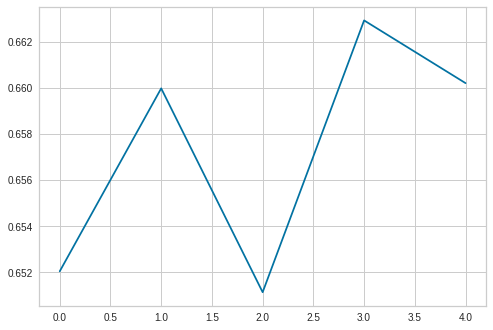

In [131]:
temp = features
target = lbls
scores = []
scores_val = []
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = LogisticRegression(multi_class='ovr')

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(accuracy_score(ytest,preds))
        scores.append(accuracy_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

In [132]:
model  = LogisticRegression(multi_class='ovr')
model.fit(X_train,Y_train)
y_pred = model.predict(X_val)
accuracy_score(y_pred,Y_val)

0.6501889644746788

## Confusion Matrix

0.6501889644746788

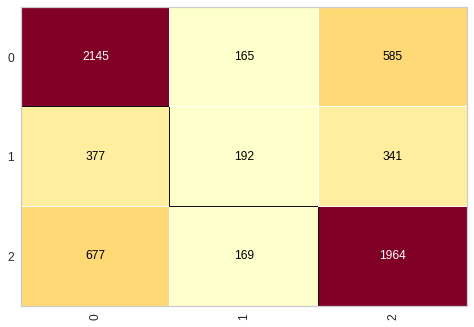

In [124]:
from yellowbrick.classifier import ConfusionMatrix
model  = LogisticRegression(multi_class='ovr')
cm = ConfusionMatrix(model=model, classes=[0,1,2])
cm.fit(X_train,Y_train)
cm.score(X_val, Y_val)


## Processing Test data

In [133]:
test_sentences = test['Cleaned_Review'].values.tolist()
sentence_model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
test_embeddings = sentence_model.encode(test_sentences)

loading configuration file /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/config.json
Model config DistilBertConfig {
  "_name_or_path": "old_models/distilbert-base-nli-mean-tokens/0_Transformer",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.9.1",
  "vocab_size": 30522
}

loading weights file /root/.cache/torch/sentence_transformers/sentence-transformers_distilbert-base-nli-mean-tokens/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoin

In [134]:
test_vector = pd.DataFrame(np.array(test_embeddings))

In [135]:
test_vector.shape

(18900, 768)

In [136]:
predictions = model.predict(test_vector)

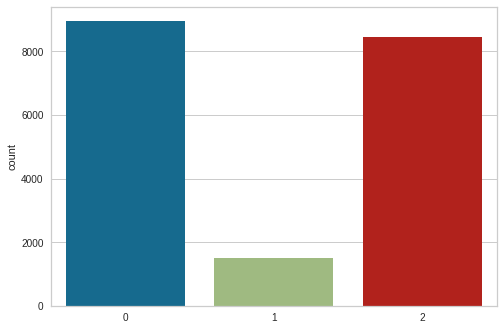

In [137]:
sns.countplot(predictions)

In [138]:
test['Sentiment'] = predictions
test['Sentiment'] = test['Sentiment'].map(labels)
test.head()

,ID,author,Review,Cleaned_Review,Sentiment,tfidf_clean_text
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,amyswarren ahhh yay getting knockin lot,Positive_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,deliverimhungry right ordered static ip set ap...,Positive_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,heard lot bad things film seeing thought negat...,Negative_0,"[0.15110701953211284, 0.0, 0.0, 0.082566337845..."
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",miss old ha ha tell person name,Negative_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,34410,phaoloo,@dharshana anytime,dharshana anytime,Neutral_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


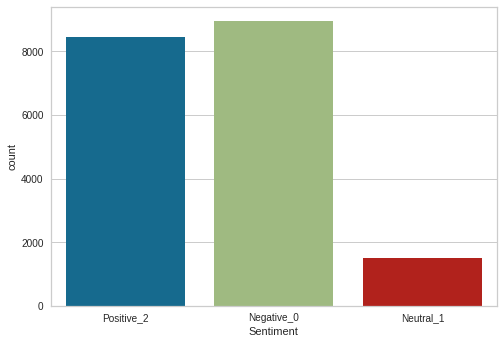

In [139]:
sns.countplot(x='Sentiment',data=test)

In [140]:
df1 = pd.get_dummies(test['Sentiment'])
df1.head()

,Negative_0,Neutral_1,Positive_2
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,0,1,0


In [142]:
df1.shape

(18900, 3)

In [141]:
df1.to_csv('sentencetransformers.csv',index=False)

## Naive Bayes

0.5524943310657596
0.5405895691609978
0.5409297052154195
0.5498866213151927
0.5494331065759637
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.5405895691609978 0.5524943310657596 0.5466666666666666


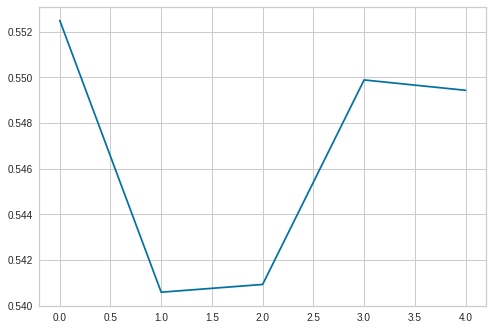

In [143]:
from sklearn.naive_bayes import GaussianNB
temp = features
target = lbls
scores = []
scores_val = []
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = GaussianNB()

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(accuracy_score(ytest,preds))
        scores.append(accuracy_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

##Lightgbm

In [144]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [146]:
lgb

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

0.6560090702947846
0.6581632653061225
0.6530612244897959
0.6568027210884354
0.6536281179138322
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.6530612244897959 0.6581632653061225 0.6555328798185942


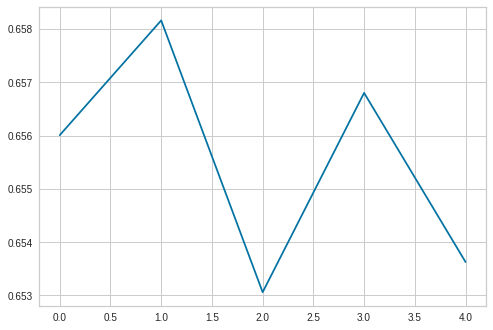

In [147]:
from sklearn.naive_bayes import GaussianNB
temp = features
target = lbls
scores = []
scores_val = []
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = LGBMClassifier()

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(accuracy_score(ytest,preds))
        scores.append(accuracy_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'num_leaves': [10, 12, 14, 16],
          'max_depth': [4, 5, 6, 8, 10],
          'n_estimators': [100,200,300],
          'is_unbalance': [True]} 

best_classifier = GridSearchCV(LGBMClassifier(random_state=42), params, cv=3, scoring="neg_log_loss")
best_classifier.fit(X_train, Y_train)